# RNNs: How To Implement A Basic RNN

## Prerequisite for Tensorflow on Python 3.12. 

The setup functionality used in pip changed and therefore both have to be reinstalled.

But then the tokenizer does not work any more. The error message is then:
No module keras.preprocessing.text
In fact checking the module there is no module text any more under preprocessing. I did not find quickly if the Tokenizer class is now in another sub module of Keras.

Solution:
- Using Python 3.10 or 3.11
- using tensorflow==2.14.0
- using keras=2.14.0


In [1]:
# !python3.12 -m pip install -U --user --upgrade setuptools wheel
# !python3.12 -m ensurepip --upgrade

In [2]:
# !python3.12 -m pip install -U --user cmake 
# !python3.12 -m pip install -U --user tf-nightly 
# !python3.12 -m pip install -U --user pandas
# !python3.12 -m pip install -U --user keras
# !python3.12 -m pip install -U --user tf-keras
# !python3.12 -m pip install -U --user scikit-learn
# !python3.12 -m pip install -U --user matplotlib

### Read In, Clean, And Split The Data

In [3]:
# Read in data and split into training and test set
# NOTE: we are NOT cleaning the data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('../../../data/spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'],
                                                    labels, test_size=0.2)

### Prep Data For Modeling

In [4]:
import keras

2024-01-05 13:51:11.845287: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-05 13:51:11.873919: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 13:51:11.873943: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 13:51:11.873958: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 13:51:11.878724: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-05 13:51:11.879506: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [5]:
# Import the tools we will need from keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


In [6]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [7]:
# Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [8]:
# What do these sequences look like?
X_train_seq[0]

[330,
 1458,
 8,
 5,
 1459,
 483,
 5,
 300,
 59,
 1460,
 18,
 41,
 42,
 927,
 1280,
 73,
 1653,
 273,
 51,
 1654,
 1655,
 20,
 1281,
 1282,
 595,
 389,
 794]

In [9]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

In [10]:
# What do these padded sequences look like?
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,  330, 1458,    8,    5, 1459,  483,    5,  300,   59, 1460,
         18,   41,   42,  927, 1280,   73, 1653,  273,   51, 1654, 1655,
         20, 1281, 1282,  595,  389,  794], dtype=int32)

### Build Model

In [11]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [12]:
# Construct a simple RNN model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0.3, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

2024-01-05 13:51:13.535056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-05 13:51:13.535497: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          255232    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 264641 (1.01 MB)
Trainable params: 264641 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [14]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10


140/140 [==============================] - 6s 26ms/step - loss: 0.2633 - accuracy: 0.9100 - precision_m: 0.4693 - recall_m: 0.4073 - val_loss: 0.0976 - val_accuracy: 0.9722 - val_precision_m: 0.9600 - val_recall_m: 0.8282
Epoch 2/10
140/140 [==============================] - 3s 23ms/step - loss: 0.0370 - accuracy: 0.9906 - precision_m: 0.9821 - recall_m: 0.9517 - val_loss: 0.0798 - val_accuracy: 0.9794 - val_precision_m: 0.9848 - val_recall_m: 0.8689
Epoch 3/10
140/140 [==============================] - 3s 23ms/step - loss: 0.0192 - accuracy: 0.9955 - precision_m: 0.9694 - recall_m: 0.9515 - val_loss: 0.0771 - val_accuracy: 0.9794 - val_precision_m: 0.9848 - val_recall_m: 0.8722
Epoch 4/10
140/140 [==============================] - 3s 23ms/step - loss: 0.0089 - accuracy: 0.9980 - precision_m: 0.9899 - recall_m: 0.9796 - val_loss: 0.0938 - val_accuracy: 0.9803 - val_precision_m: 0.9943 - val_recall_m: 0.8727
Epoch 5/10
140/140 [==============================] - 3s 23ms/step - loss: 0.00

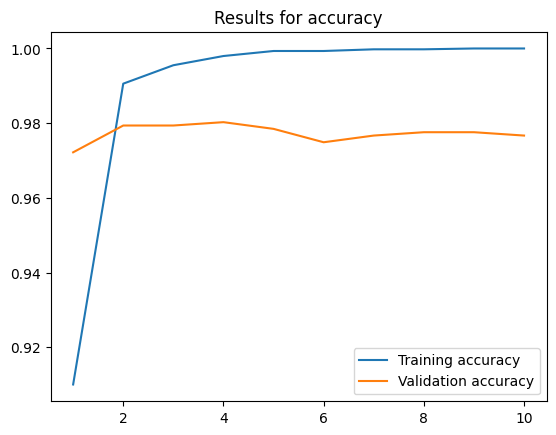

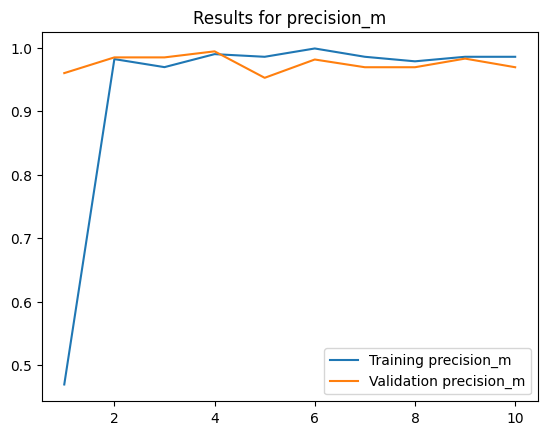

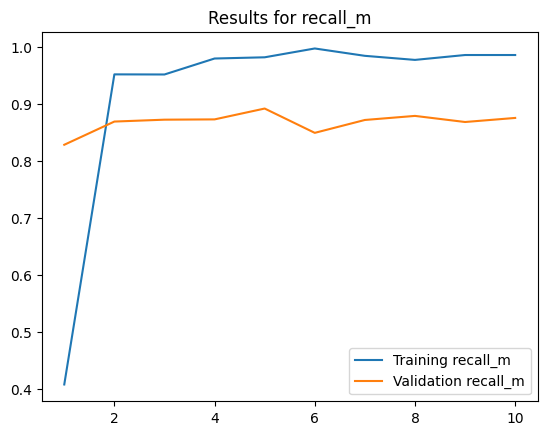

In [15]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training ' + i)
    plt.plot(epochs, val_acc, label='Validation '  + i)
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()